# Chicago Ride-Share Analysis

Understanding Chicago's ride-sharing dynamics requires examining multiple data sources to spot meaningful trends. Specifically for the new company Zuber, I will use three core datasets - ride volumes from existing providers, neighborhood-specific trip records, and detailed weather logs - all compiled using SQL from previous tasks. This analysis focuses meaningful patterns in rider behavior across different city areas and weather scenarios. These findings offer guidance for operational adjustments in driver allocation and service availability. 

## Exploratory Data Analysis

In [1]:
# loading all the libraries
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display_html
from scipy import stats as st
import plotly.express as px
import seaborn as sns
import numpy as np

In [2]:
company = pd.read_csv('/datasets/project_sql_result_01.csv')
chicago = pd.read_csv('/datasets/project_sql_result_04.csv')
weather = pd.read_csv('/datasets/project_sql_result_07.csv')

In [3]:
chicago_c = chicago.head().style.set_caption(
    "Average number of rides that ended in each neighborhood in November 2017").format({'average_trips': '{:.2f}'})
company_c = company.head().style.set_caption("Number of rides for each taxi company on November 15-16, 2017")

display_html(f'''<div style="display: flex; align-items: stretch; gap: 50px;">
        {company_c.render().replace('table', 'table style="height: 100%;"')}
        {chicago_c.render().replace('table', 'table style="height: 100%;"')} </div> ''', raw=True)

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
,dropoff_location_name,average_trips
0,Loop,10727.47
1,River North,9523.67
2,Streeterville,6664.67
3,West Loop,5163.67


In [4]:
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [5]:
company.duplicated(subset=['company_name']).sum()

0

In [6]:
chicago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [7]:
chicago['average_trips'] = chicago['average_trips'].astype(int)
chicago.duplicated(subset=['dropoff_location_name']).sum()

0

After compiling the ride data, I've reviewed both datasets - one showing ride volumes by taxi company, and the other tracking average trip counts across Chicago neighborhoods. Checking the data types adjusting everything is properly formatted: company names and neighborhood IDs as objects, trip counts as integers, and average trips as floats. With no type mismatches or dupilcates, the datasets appear clean and ready for analysis. The initial validation gives me confidence in the data quality before diving deeper into patterns and trends.

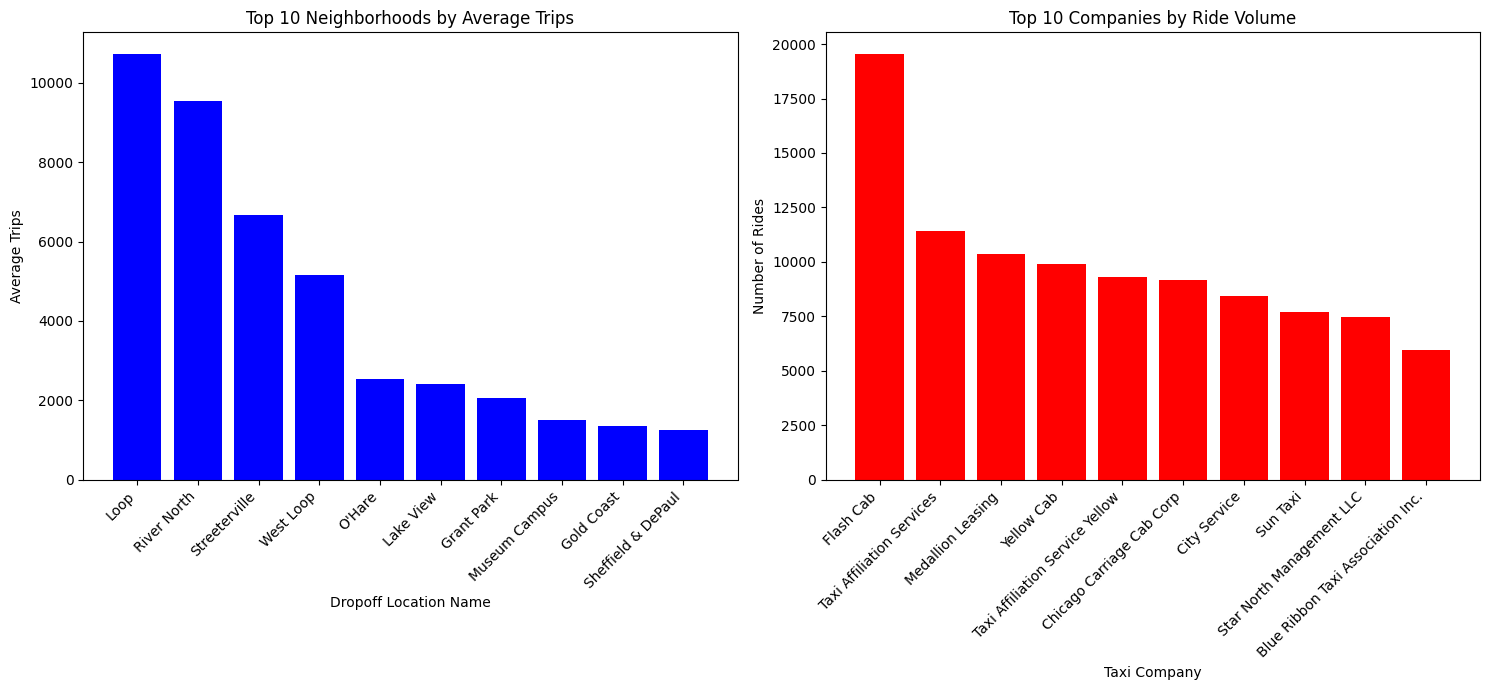

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

top_10_neighborhoods = chicago.sort_values('average_trips', ascending=False).head(10)
bars1 = ax1.bar(top_10_neighborhoods['dropoff_location_name'], 
                top_10_neighborhoods['average_trips'], color='blue')
ax1.set_xlabel('Dropoff Location Name')
ax1.set_ylabel('Average Trips')
ax1.set_title('Top 10 Neighborhoods by Average Trips')
ax1.set_xticks(range(len(top_10_neighborhoods)))
ax1.set_xticklabels(top_10_neighborhoods['dropoff_location_name'], rotation=45, ha='right')

top_10_companies = company.sort_values('trips_amount', ascending=False).head(10)
bars2 = ax2.bar(top_10_companies['company_name'], top_10_companies['trips_amount'], color='red')
ax2.set_xlabel('Taxi Company')
ax2.set_ylabel('Number of Rides')
ax2.set_title('Top 10 Companies by Ride Volume')
ax2.set_xticks(range(len(top_10_companies)))
ax2.set_xticklabels(top_10_companies['company_name'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

The left bar chart reveals clear patterns in Chicago's ride demand distribution across neighborhoods. The Loop stands out dramatically with approximately 10,000 average trips, solidifying its position as the city's primary transportation hub. This dominance shows its concentration of corporate offices, tourist attractions, and transit connections. River North and Streeterville have a distinct second tier, benefiting from their vibrant mix of dining, entertainment, and residential density. After these top three locations, the chart shows a steady decline through neighborhoods before reaching Lake View and Gold Coast at just 2,000 trips. This gradient suggests a direct correlation between a neighborhood's commercial activity and its ride demand. Transportation planners should prioritize resources for the downtown core while still maintaining service for secondary neighborhoods that show consistent demand patterns.

On the other hand, the right bar chart shows the taxi company performance. Flash Cab's commanding lead with 20,000 trips suggests strong brand loyalty and/or operational efficiency in high-demand areas. Taxi Affiliation Services and Medallion Leasing maintain respectable but significantly lower volumes at 17,500 and 16,000 trips respectively, representing viable competitors but lacking Flash Cab's market penetration. From the Yellow Cab's 7,500 trips, the amount of rides per company dramatically decrease, with Blue Ribbon Taxi scraping just 2,500 trips. This distribution implies barriers to growth for smaller companies, whether from taxi number limitations or inability to compete in prime locations.

## Testing Hypothesis

To assess whether there is a statistically significant difference in average ride durations from the Loop to O'Hare International Airport on rainy Saturdays, I will begin by examining the weather data for potential outliers, extreme values that can distort the results of a t-test by inflating variance or shifting the mean. 

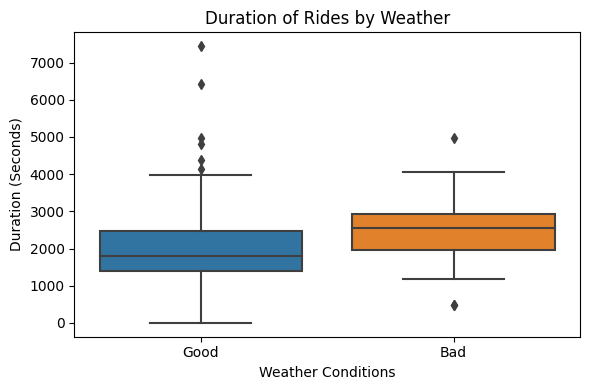

In [9]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='weather_conditions', y='duration_seconds', 
            data=weather[['weather_conditions', 'duration_seconds']])
plt.title("Duration of Rides by Weather")
plt.xlabel("Weather Conditions")
plt.ylabel("Duration (Seconds)")
plt.tight_layout()
plt.show()

The boxplot shows distinct patterns in ride durations between good and bad weather conditions. Under good weather, numerous outliers suggest greater variability in trip times, likely reflecting that people take longer, more discretionary trips (like leisure activities or multiple stops) when conditions are favorable. On the other hand, the bad weather plot shows fewer outliers, possibly having direct commutes with less deviation from typical routes. The median duration appears slightly higher for bad weather trips, which could mean slower traffic speeds during rain or snow. Notably, the fewer amount of short trips in bad weather also suggests that people rarely abandon trips when conditions worsen, while others who are riding in good weather may tend to shorten trips to walk to their destination instead. These patterns collectively indicate that weather significantly influences not just ride frequency but also the nature and duration of trips taken.

Since there are many outliers in the good weather condition for the duration of the rides, it is obvious that this could skew the hypothesis testing, possibly causing a Type 1 error or reduced statistical power. To prevent this, I will remove the top 5 longest trips from the Good weather conditions before testing using a two-tailed test with a significance level (α) of 0.05. From here, this approach will help determine whether the differences in average user ratings are statistically significant or due to random variation. The findings will provide valuable insights into whether one platform or genre consistently receives higher user ratings than the other.

Null Hypothesis (H₀): There is no significant difference in the average duration of rides from the Loop to O'Hare International Airport on rainy Saturdays.

Alternative Hypothesis (H₁): There is a significant difference in the average duration of rides from the Loop to O'Hare International Airport on rainy Saturdays.

In [10]:
rain = weather[weather['weather_conditions'] == 'Bad']['duration_seconds']
no_rain = weather[weather['weather_conditions'] == 'Good']['duration_seconds']
no_rain_filtered = no_rain.sort_values().iloc[:-5]
results = st.ttest_ind(rain, no_rain_filtered, equal_var=False)

if (results.pvalue < 0.05):
    print(f'We reject the null hypothesis since the p-value is {results.pvalue}')
else:
    print(f"We fail to reject the null hypothesis since the p-value is {results.pvalue}")

We reject the null hypothesis since the p-value is 5.01492113268104e-13


As shown by the p-value, it is drastically over 0.05, meaning that null hypothesis cannot be rejected. Therefore, there is no significant difference in the average duration of rides from the Loop to O'Hare International Airport on rainy Saturdays.

## Conclusion

Using the three core datasets of Chicago's ride-sharing dynamics that were compiled through SQL, I have found insights for Zuber's market strategy. The neighborhood demand analysis revealed The Loop as the dominant transportation hub with approximately 10,000 average trips, followed by secondary hotspots like River North and Streeterville, suggesting Zuber should prioritize downtown fleet allocation while maintaining service in residential areas showing steady demand. The competitive landscape analysis highlighted Flash Cab's market leadership with 20,000 trips, indicating the importance of brand recognition. The hypothesis test on weather impacts showed no statistically significant difference in ride durations to O'Hare Airport on rainy Saturdays, though further research could explore other weather-related demand patterns. With these insights, Zuber is ready to enter the Chicago market with competitive strategies tailored to rider behavior and market gaps.